In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from linearmodels.panel import PooledOLS

# 1. VAR Process

In the data `raotb16.csv` we have some macroeconomic data.

1. Test which series Granger cause each other.

2. Test which series are stationary

3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

In [2]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('data/raotb16.csv', index_col='date',
                parse_dates = ['date'], date_parser = dateparse)
df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


In [3]:
model = VAR(np.asarray(df))
results = model.fit()
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Apr, 2021
Time:                     16:57:54
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -1.63501
Nobs:                     122.000    HQIC:                  -2.61770
Log likelihood:          -1112.20    FPE:                  0.0373400
AIC:                     -3.28984    Det(Omega_mle):       0.0211292
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -54.935287        39.419449           -1.394           0.163
L1.y1         0.825827         0.041656           19.825           0.000
L1.y2         0.241602         0.054422            4.439           0.000
L1.y3        -4.227676

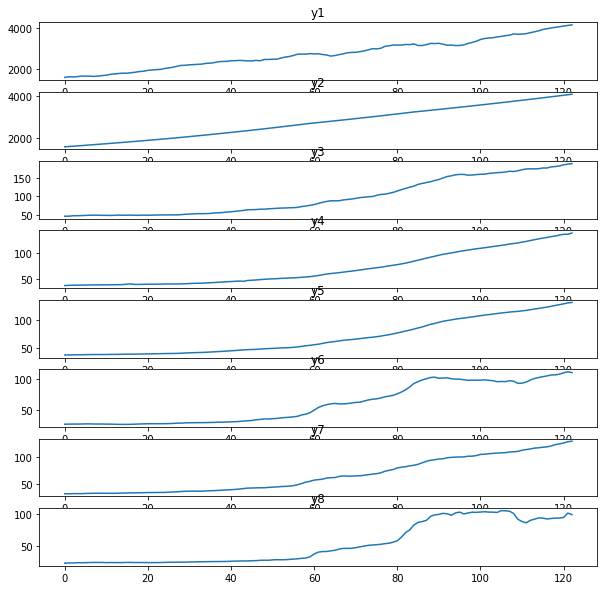

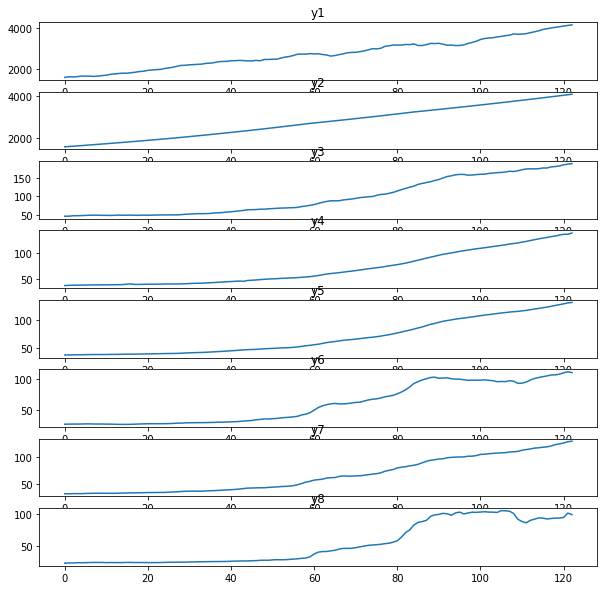

In [4]:
results.plot()

In [5]:
model.select_order(5)

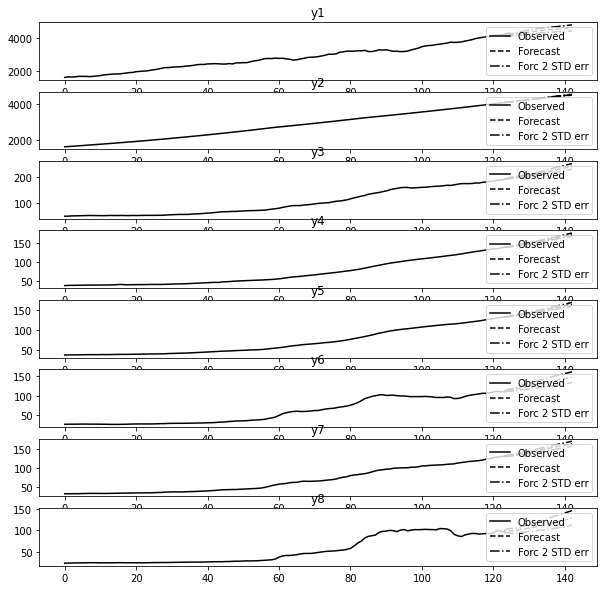

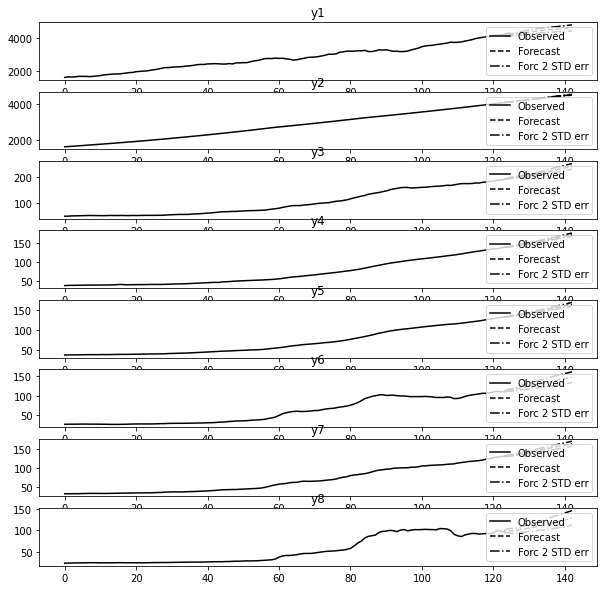

In [6]:
results = model.fit(maxlags=5, ic='aic')
results.plot_forecast(20)

In [7]:
results.test_causality('y1', ['y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.788,1.442,0.000,"(35, 616)"


In [8]:
results.test_causality('y2', ['y1', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.421,1.442,0.000,"(35, 616)"


In [9]:
results.test_causality('y3', ['y2', 'y1', 'y4', 'y5', 'y6', 'y7', 'y8'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.266,1.442,0.000,"(35, 616)"


In [10]:
results.test_causality('y4', ['y2', 'y3', 'y1', 'y5', 'y6', 'y7', 'y8'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.540,1.442,0.000,"(35, 616)"


In [11]:
results.test_causality('y5', ['y2', 'y3', 'y4', 'y1', 'y6', 'y7', 'y8'], kind='f').summary()

Test statistic,Critical value,p-value,df
4.583,1.442,0.000,"(35, 616)"


In [12]:
results.test_causality('y6', ['y2', 'y3', 'y4', 'y5', 'y1', 'y7', 'y8'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.445,1.442,0.000,"(35, 616)"


In [13]:
results.test_causality('y7', ['y2', 'y3', 'y4', 'y5', 'y6', 'y1', 'y8'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.504,1.442,0.000,"(35, 616)"


In [14]:
results.test_causality('y8', ['y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y1'], kind='f').summary()

Test statistic,Critical value,p-value,df
2.355,1.442,0.000,"(35, 616)"


In [15]:
rgnp = df.loc[:, df.columns.intersection(['rgnp'])]
pgnp = df.loc[:, df.columns.intersection(['pgnp'])]
ulc = df.loc[:, df.columns.intersection(['ulc'])]
gdfco = df.loc[:, df.columns.intersection(['gdfco'])]
gdf = df.loc[:, df.columns.intersection(['gdf'])]
gdfim = df.loc[:, df.columns.intersection(['gdfim'])]
gdfcf = df.loc[:, df.columns.intersection(['gdfcf'])]
gdfce = df.loc[:, df.columns.intersection(['gdfce'])]

In [16]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

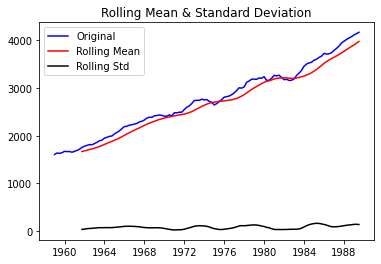

Results of Dickey-Fuller Test:


Test Statistic                   0.641882
p-value                          0.988604
#Lags Used                       2.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64

In [17]:
test_stationarity(rgnp)

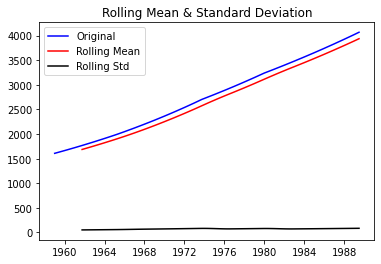

Results of Dickey-Fuller Test:


Test Statistic                   1.274320
p-value                          0.996461
#Lags Used                       1.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64

In [18]:
test_stationarity(pgnp)

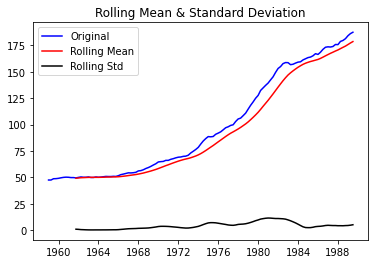

Results of Dickey-Fuller Test:


Test Statistic                   1.396716
p-value                          0.997099
#Lags Used                       2.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64

In [19]:
test_stationarity(ulc)

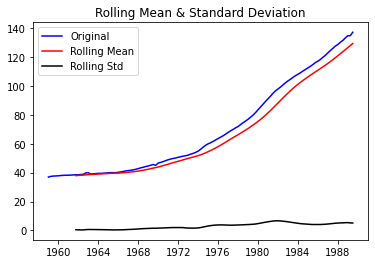

Results of Dickey-Fuller Test:


Test Statistic                   0.576191
p-value                          0.987014
#Lags Used                       5.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64

In [20]:
test_stationarity(gdfco)

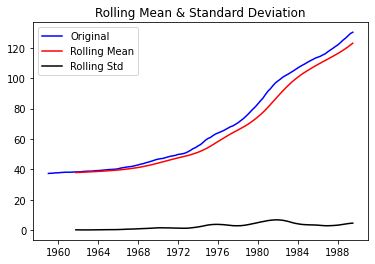

Results of Dickey-Fuller Test:


Test Statistic                   1.112860
p-value                          0.995325
#Lags Used                       7.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64

In [21]:
test_stationarity(gdf)

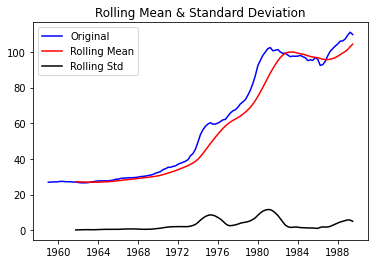

Results of Dickey-Fuller Test:


Test Statistic                  -0.198720
p-value                          0.938674
#Lags Used                       1.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64

In [22]:
test_stationarity(gdfim)

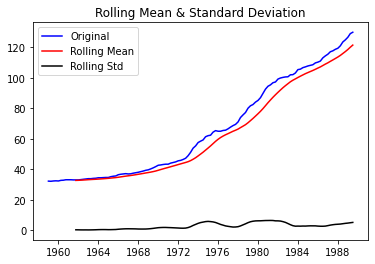

Results of Dickey-Fuller Test:


Test Statistic                   1.669255
p-value                          0.998051
#Lags Used                       9.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64

In [23]:
test_stationarity(gdfcf)

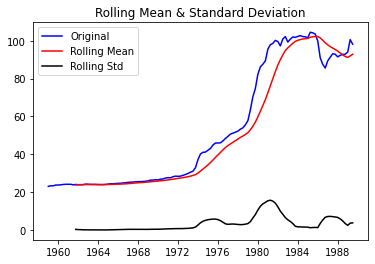

Results of Dickey-Fuller Test:


Test Statistic                  -0.815918
p-value                          0.814402
#Lags Used                      13.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64

In [24]:
test_stationarity(gdfce)

In [25]:
df_train = df.iloc[:-4]
df_test = df.iloc[-4:]

In [26]:
model = VAR(np.asarray(df_train))
results = model.fit()
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Apr, 2021
Time:                     16:57:59
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -2.23006
Nobs:                     118.000    HQIC:                  -3.23422
Log likelihood:          -1036.16    FPE:                  0.0198753
AIC:                     -3.92065    Det(Omega_mle):       0.0110393
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -58.789166        41.070291           -1.431           0.152
L1.y1         0.827336         0.042646           19.400           0.000
L1.y2         0.237786         0.056609            4.200           0.000
L1.y3        -4.440460

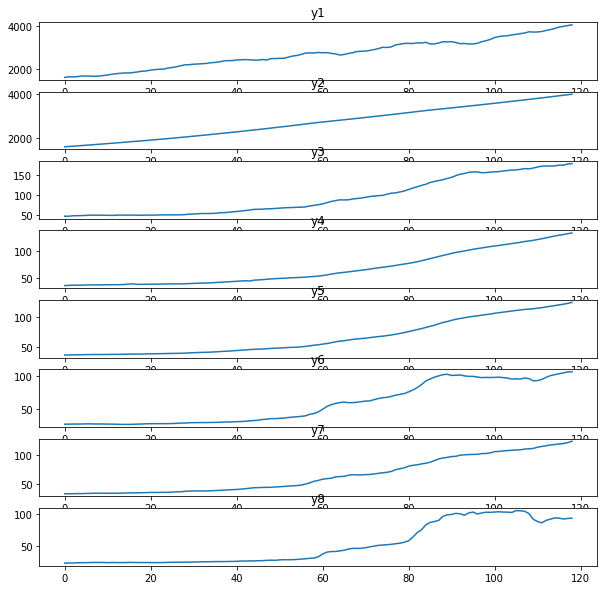

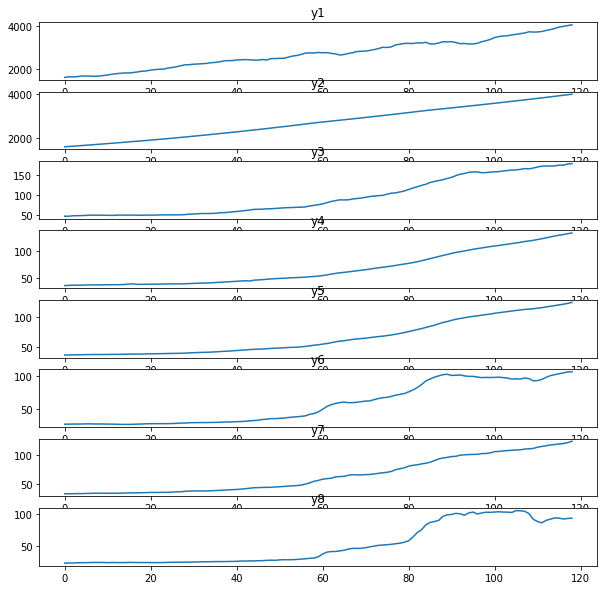

In [27]:
results.plot()

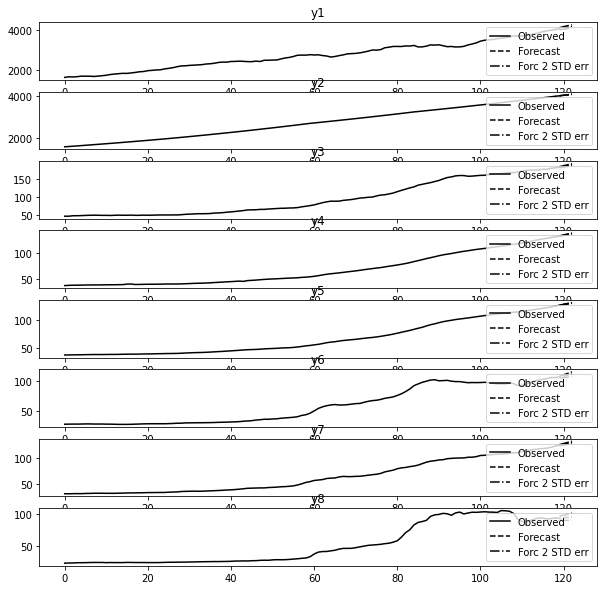

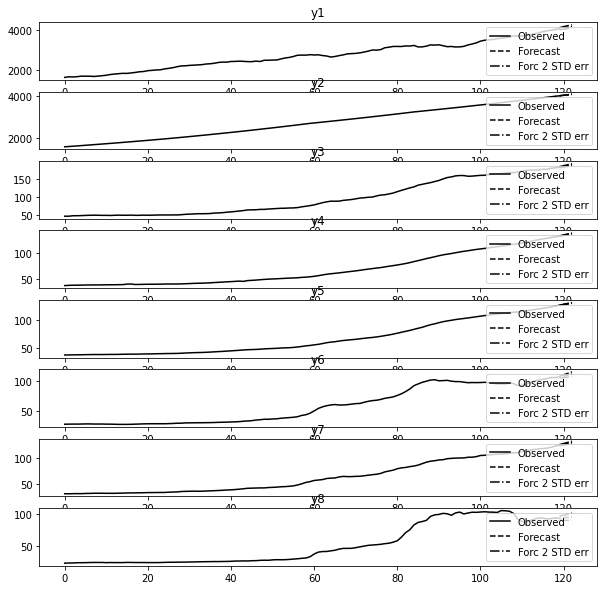

In [28]:
results.plot_forecast(4)

# 2. Gun Violence Panel

The [Gun Violence](https://www.kaggle.com/jameslko/gun-violence-data) dataset

1. Transform it into an amenable panel (or structure of multiple time series) to analyze and create a forecast for the next year outside the sample in **Chicago**, **Washington** and **New Orleans**, and the US as a whole.

2. Are there other (non time series) predictors which could be used in this dataset to help predict severity or number of shootings in the future? Analyze the data for feature importance and explain your findings.

In [29]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv("data/gun-violence-data_01-2013_03-2018.csv", index_col='date',
                parse_dates = ['date'], date_parser = dateparse) # Downloaded the csv files
df['n_affected'] = df['n_killed'] + df['n_injured']
df

,incident_id,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,n_affected
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,461105,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,4
2013-01-01,460726,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,4
2013-01-01,478855,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,4
2013-01-05,478925,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,6.0,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,4
2013-01-07,478959,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,6.0,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31,1083142,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,NaN,...,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.klfy.com/news/local/rayne-woman-cha...,NaN,NaN,0
2018-03-31,1083139,Louisiana,Natchitoches,247 Keyser Ave,1,0,http://www.gunviolencearchive.org/incident/108...,http://www.ksla.com/story/37854648/man-wanted-...,False,4.0,...,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Jamal Haskett||1::Jaquarious Tyjuan Ardison,NaN,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,http://www.ksla.com/story/37854648/man-wanted-...,23.0,31.0,1
2018-03-31,1083151,Louisiana,Gretna,1300 block of Cook Street,0,1,http://www.gunviolencearchive.org/incident/108...,http://www.nola.com/crime/index.ssf/2018/04/sh...,False,2.0,...,0::Adult 18+,0::Male,NaN,NaN,0::Injured,0::Victim,http://www.nola.com/crime/index.ssf/2018/04/sh...,85.0,7.0,1


In [30]:
ch = df.loc[df.city_or_county == 'Chicago'].loc[:, df.columns.intersection(['n_affected'])]
wa = df.loc[df.city_or_county == 'Washington'].loc[:, df.columns.intersection(['n_affected'])]
no = df.loc[df.city_or_county == 'New Orleans'].loc[:, df.columns.intersection(['n_affected'])]
us = df.loc[:, df.columns.intersection(['n_affected'])]

In [31]:
def preds(name):
    df_train = name.iloc[:-12]
    df_test = name.iloc[-12:]

    model = ARIMA(df_train, order=(2, 1, 0))
    res = model.fit()
    pred = res.predict(len(name), len(name)+4)
    return pred

In [32]:
preds(ch)

C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

10814    0.831039
10815    0.830344
10816    0.830487
10817    0.830614
10818    0.830484
Name: predicted_mean, dtype: float64

In [33]:
preds(wa)

C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

3279    0.625563
3280    0.625594
3281    0.625268
3282    0.625454
3283    0.625446
Name: predicted_mean, dtype: float64

In [34]:
preds(no)

C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

3071    1.321899
3072    1.321792
3073    1.321629
3074    1.321767
3075    1.321734
Name: predicted_mean, dtype: float64

In [35]:
preds(us)

C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\gaia_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction resul

239677    1.165520
239678    1.165313
239679    1.165487
239680    1.165439
239681    1.165414
Name: predicted_mean, dtype: float64

<font color=green>Based on the information in the dataset, we could see the number of incidents at state, county, or city level. Alternatively we can consider the effect of age and gender on the number of crimes.</font>

In [36]:
from linearmodels.panel import PooledOLS

data = df.reset_index().set_index(['incident_id', 'date'])

exog_vars = ['n_killed', 'n_injured', 'congressional_district',
       'latitude', 'longitude', 'n_guns_involved', 'state_house_district',
       'state_senate_district', 'n_affected']
exog = sm.add_constant(data[exog_vars])
mod = PooledOLS(data['n_affected'], exog, check_rank=False)
pooled_res = mod.fit()
print(pooled_res)

C:\Users\gaia_\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PooledOLS Estimation Summary                          
Dep. Variable:             n_affected   R-squared:                        1.0000
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:              112636   R-squared (Within):               0.0000
Date:                Tue, Apr 27 2021   R-squared (Overall):              1.0000
Time:                        16:58:19   Log-likelihood                 3.856e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   9.228e+34
Entities:                      112636   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                F(9,112626)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):         -1.772e+37
                            